# Import

In [6]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

## Add configuration file

In [7]:
sys.path.append("/home/jovyan/core/config/")
sys.path.append("/home/jovyan/core/util/")
sys.path.append("../PlotFunction/lineplot/")
sys.path.append("../PlotFunction/config/")

In [8]:
from ALL import config
from line_plot_1 import line_plot_1
from line_plot_error_1 import line_plot_error_1
from line_plot_error_1_layout import layout
from util import *

## Set condition

In [9]:
tqdm.pandas()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)

In [17]:
data_type = "20News"
vectorize_type = "sentenceBERT"

# Read data

In [18]:
df = pd.read_csv(
    f"../../Preprocessing/data/{data_type}/master.csv", index_col=0
)

In [19]:
with open(f"../../Preprocessing/data/{data_type}/class.csv", mode="r") as f:
    reader = csv.reader(f)
    class_labels = [label for label in reader]

In [20]:
vector_dims = config["vectorize"]["doc2vec"]["dims"]
model_nums = config["clustering"]["gmm"]["max_model_num"]
vector_model_num = config["vectorize"]["doc2vec"]["max_model_num"]
normalization = config["vectorize"][vectorize_type]["normalization"]
covariance_types = ['spherical', 'diag', 'full']

In [21]:
stats_vals = ["aic", "bic", "mi", "logl"]

In [22]:
# データ型定義
stats = {
    stats_val: {
        covariance_type: {model_num: pd.DataFrame for model_num in range(model_nums)}
        for covariance_type in covariance_types
    }
    for stats_val in stats_vals
}

# データ取得
for stats_val in stats_vals:
    for covariance_type in covariance_types:
        for model_num in range(model_nums):
            stats_path = f"../../Postprocessing/data/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{covariance_type}/{model_num}.csv"
            df = pd.read_csv(stats_path, index_col=0)
            stats[stats_val][covariance_type][model_num] = df.loc[:, stats_val]

In [23]:
lda_mi = pd.read_csv(f"../../Postprocessing/data/{data_type}/LDA/mi.csv", index_col=0)

In [24]:
describe_lda_mi, _ = get_describe(lda_mi, axis=0)

# Data shaping

In [25]:
stats_df = {
    stats_val: {covariance_type: pd.DataFrame() for covariance_type in covariance_types}
    for stats_val in stats_vals
}

for stats_val in stats_vals:
    for covariance_type in covariance_types:
        # model_numについて取得データstatsを結合
        stats_df[stats_val][covariance_type] = pd.concat(
            stats[stats_val][covariance_type], axis=1
        )

In [26]:
describe = {
    stats_val: {covariance_type: dict() for covariance_type in covariance_types}
    for stats_val in stats_vals
}

for stats_val in stats_vals:
    for covariance_type in covariance_types:
        describe[stats_val][covariance_type], describe_keys = get_describe(
            stats_df[stats_val][covariance_type], axis=1
        )

In [27]:
data = {
    stats_val: {describe_key: pd.DataFrame() for describe_key in describe_keys}
    for stats_val in stats_vals
}
for stats_val in stats_vals:
    for describe_key in describe_keys:
        # covariance_typeについてデータを結合
        _data = {
            covariance_type: describe[stats_val][covariance_type][describe_key]
            for covariance_type in covariance_types
        }
        data[stats_val][describe_key] = pd.concat(_data, axis=1)

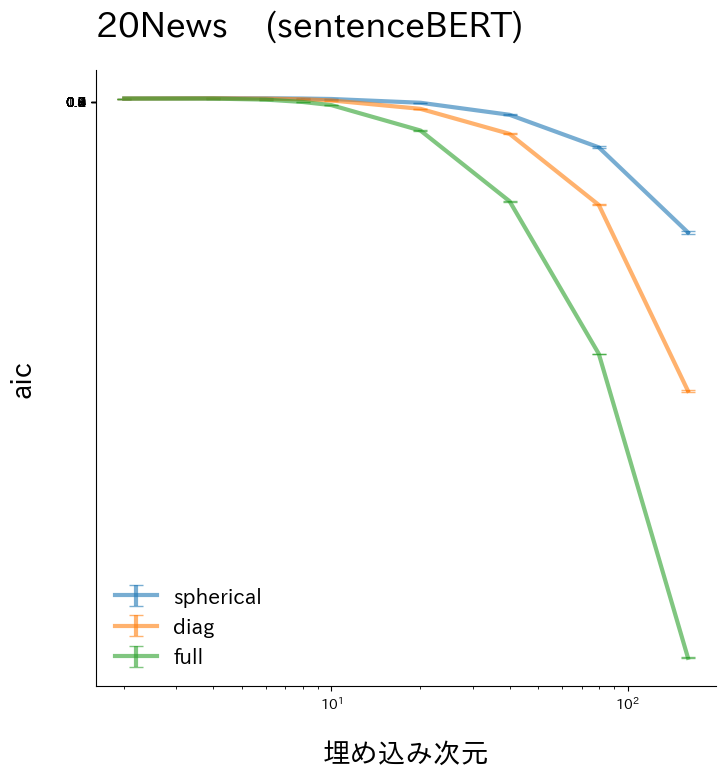

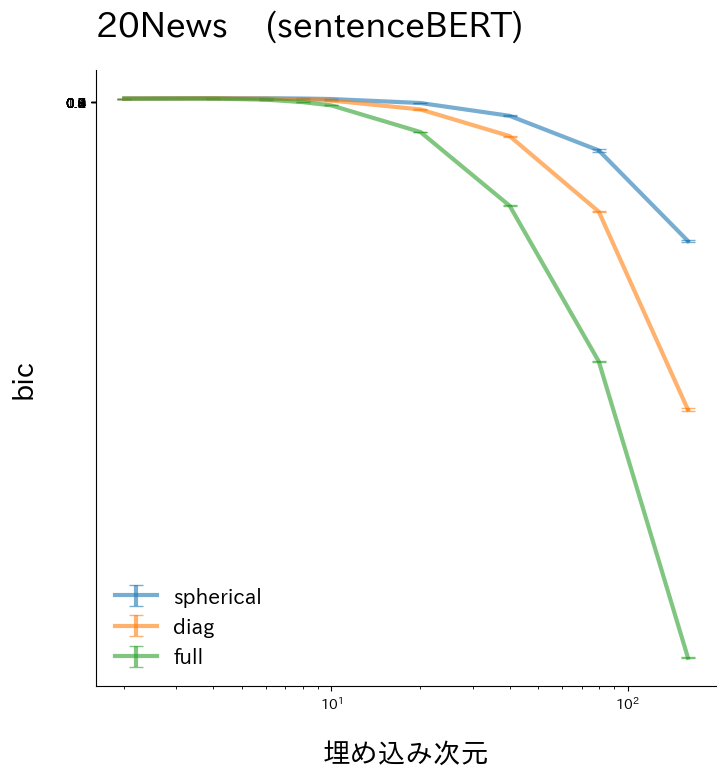

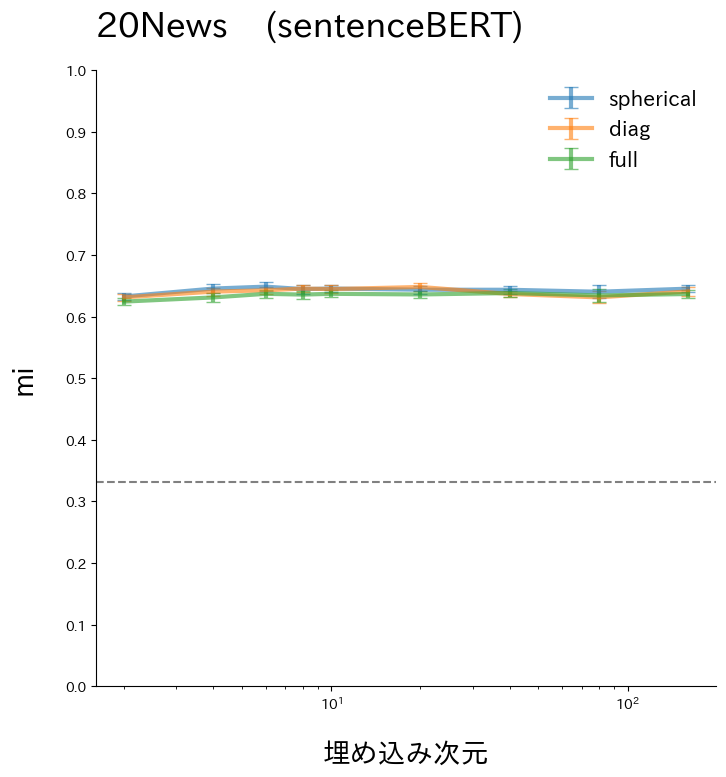

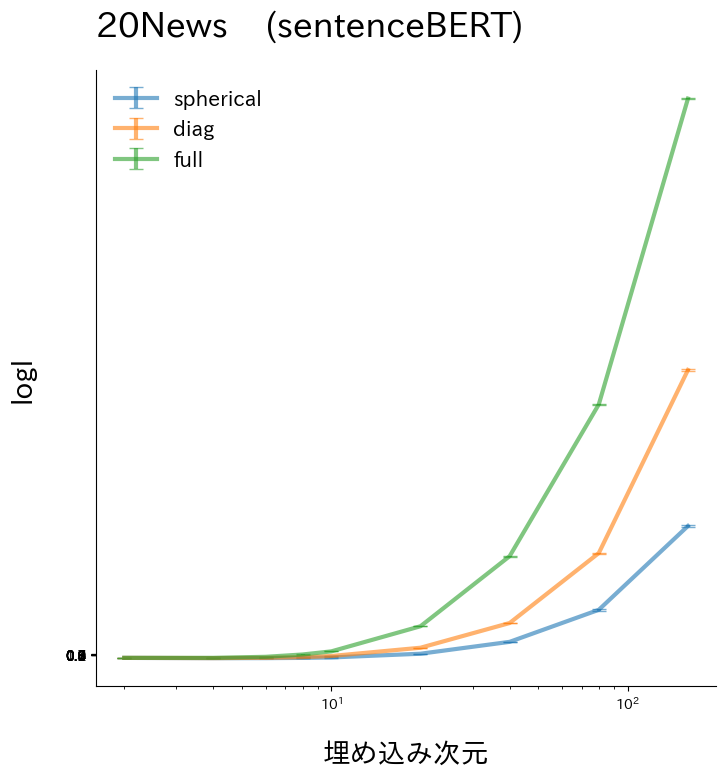

In [28]:
for stats_val in stats_vals:
    fig = plt.figure(**layout["figure"])
    ax = fig.add_subplot(111)
    fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/{normalization}/{stats_val}.pdf"
    ax.set_xscale("log")
    line_plot_error_1(
        data[stats_val]["mean"],
        error_low=data[stats_val]["std"],
        error_upper=data[stats_val]["std"],
        fig=fig,
        ax=ax,
        layout=layout,
        title=f"{data_type}    ({vectorize_type})",
        xlabel="埋め込み次元",
        ylabel=stats_val,
        yticks=np.arange(0, 1.1, 0.1),
        path=fig_path,
    )
    if stats_val == "mi":
        ax.axhline(
            y=describe_lda_mi["mean"].to_numpy(), linestyle="dashed", color="gray"
        )

In [29]:
error_low=data["mi"]["std"]
error_upper=data["mi"]["std"]
title=f"{data_type}    ({vectorize_type})"
xlabel="埋め込み次元"
ylabel="mi"
yticks=np.arange(0, 1.1, 0.1)
path=fig_path

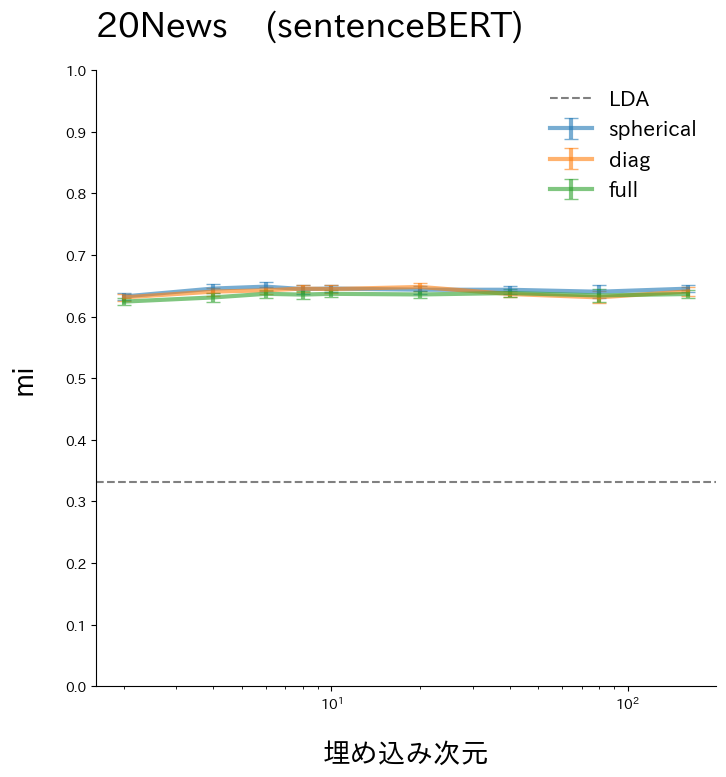

In [30]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/mi.pdf"
ax.set_xscale("log")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for column in data["mi"]["mean"].columns:
    ax.errorbar(
        x=data["mi"]["mean"].index.to_numpy(),
        y=data["mi"]["mean"].loc[:, column].to_numpy(),
        yerr=np.stack(
            [
                error_low.loc[:, column].to_numpy(),
                error_upper.loc[:, column].to_numpy(),
            ],
        ),
        label=column,
        **layout["plot"],
    )

ax.axhline(
    y=describe_lda_mi["mean"].to_numpy(), linestyle="dashed", color="gray", label="LDA"
)

ax.set_title(title, **layout["title"])

ax.set_xlabel(xlabel, **layout["label"])
ax.set_ylabel(ylabel, **layout["label"])
ax.set_yticks(ticks=yticks, **layout["ticks"])
ax.legend(**layout["legend"])

fig.savefig(make_filepath(fig_path))

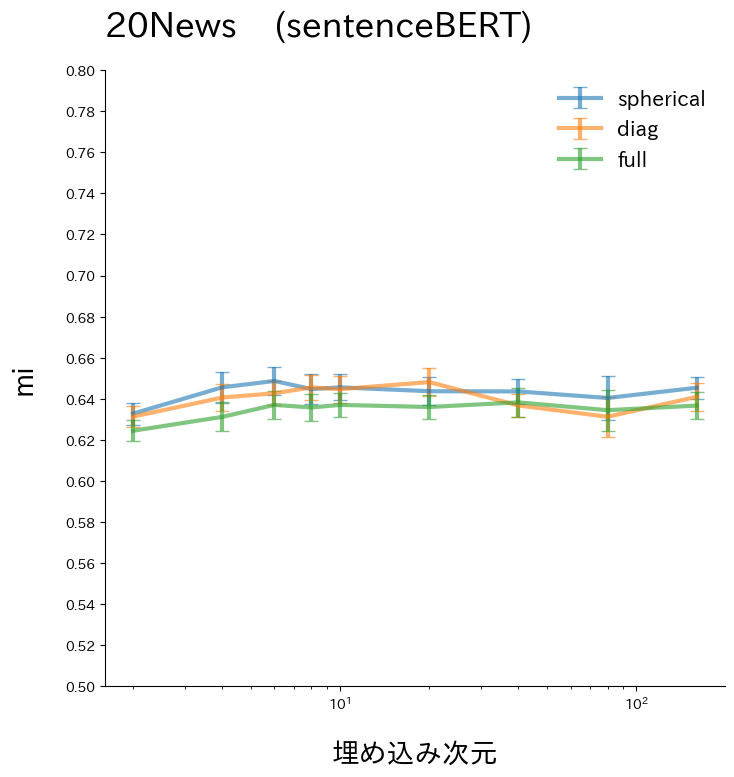

In [34]:
fig = plt.figure(**layout["figure"])
ax = fig.add_subplot(111)
fig_path = f"../data/figure/{data_type}/{vectorize_type}/GMM/stats/mi.pdf"
ax.set_xscale("log")
line_plot_error_1(
    data["mi"]["mean"],
    error_low=data["mi"]["std"],
    error_upper=data["mi"]["std"],
    fig=fig,
    ax=ax,
    layout=layout,
    title=f"{data_type}    ({vectorize_type})",
    xlabel="埋め込み次元",
    ylabel="mi",
    yticks=np.arange(0.5, 0.8, 0.02),
    path=fig_path,
)

# ax.axhline(
#     y=describe_lda_mi["mean"].to_numpy(), linestyle="dashed", color="gray"
# )